In [1]:
import sys
print(sys.executable)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# Importaciones necesarias
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

# Agregar la ruta de los scripts al sistema
import sys
sys.path.append(os.path.abspath("../scripts"))

# Importar el modelo y las clases de datasets
from scripts.model import MILModel
from data.datasets.SCStandardMILDataset import SCStandardMILDataset
from data.datasets.MCStandardMILDataset import MCStandardMILDataset
from data.datasets.FalseFrequencyMILDataset import FalseFrequencyMILDataset

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
# Configuración general
DATA_DIR = "../data/datasets"  # Carpeta donde están los datasets
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
FEATURE_DIM = 128
POOLING_TYPE = "attention"  # Opciones: 'attention', 'mean', 'max'

# Parámetros específicos de los datasets
D = 10  # Dimensionalidad de los datos
NUM_BAGS = 100  # Número de bolsas
B = 5  # Número de instancias negativas por bolsa
POS_CLASS_PROB = 0.5  # Probabilidad de que una bolsa sea positiva
SEED = 42  # Semilla para reproducibilidad

In [5]:
# Crear instancias de los datasets
sc_dataset = SCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

mc_dataset = MCStandardMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

false_freq_dataset = FalseFrequencyMILDataset(
    D=D,
    num_bags=NUM_BAGS,
    B=B,
    pos_class_prob=POS_CLASS_PROB,
    train=True,
    seed=SEED
)

# Crear dataloaders
sc_loader = DataLoader(sc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=sc_dataset.collate_fn)
mc_loader = DataLoader(mc_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=mc_dataset.collate_fn)
false_freq_loader = DataLoader(false_freq_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=false_freq_dataset.collate_fn)

=== SCStandard Dataset ===
Bag Label: tensor(1)
Instance Labels: tensor([1., 0., 0., 0., 0., 0.])


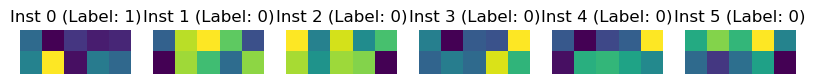

=== MCStandard Dataset ===
Bag Label: tensor(0)
Instance Labels: tensor([-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2., -2., -2., -2.])


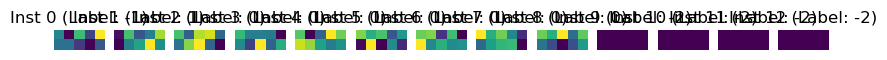

=== False Frequency Dataset ===
Bag Label: tensor(1)
Instance Labels: tensor([ 1.,  1.,  0.,  0.,  0.,  0.,  0., -2., -2., -2.])


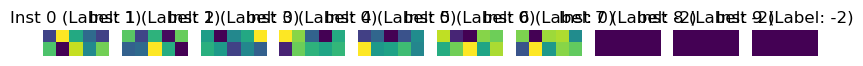

In [16]:
def visualize_bag(bag_data, bag_label, instance_labels):
    """
    Visualiza una bolsa de instancias junto con sus etiquetas.
    """
    print("Bag Label:", bag_label)
    print("Instance Labels:", instance_labels)
    plt.figure(figsize=(10, 5))
    for i, instance in enumerate(bag_data):
        plt.subplot(1, len(bag_data), i + 1)
        plt.title(f"Inst {i} (Label: {instance_labels[i].item():.0f})")
        plt.imshow(instance.numpy().reshape(2, -1), cmap="viridis")
        plt.axis("off")
    plt.show()

# Visualizar un ejemplo de cada dataset
print("=== SCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== MCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in mc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== False Frequency Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in false_freq_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

=== SCStandard Dataset ===


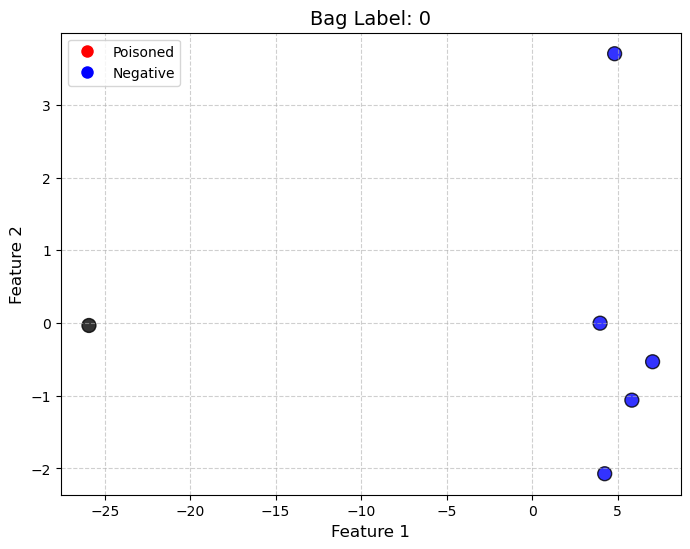

=== MCStandard Dataset ===


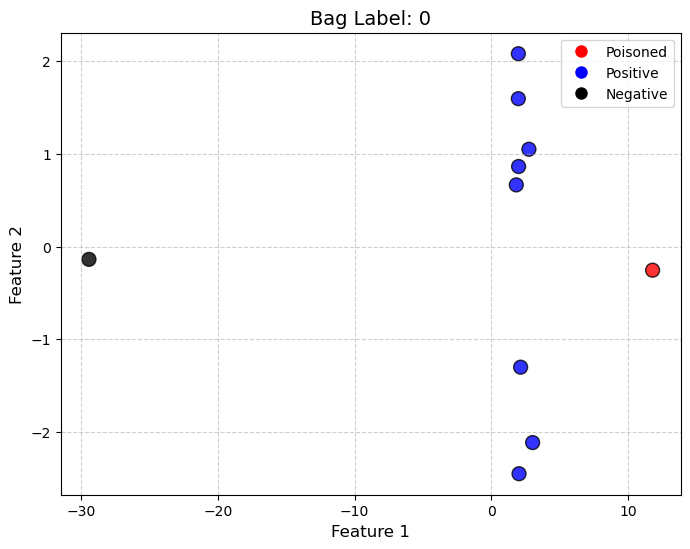

=== False Frequency Dataset ===


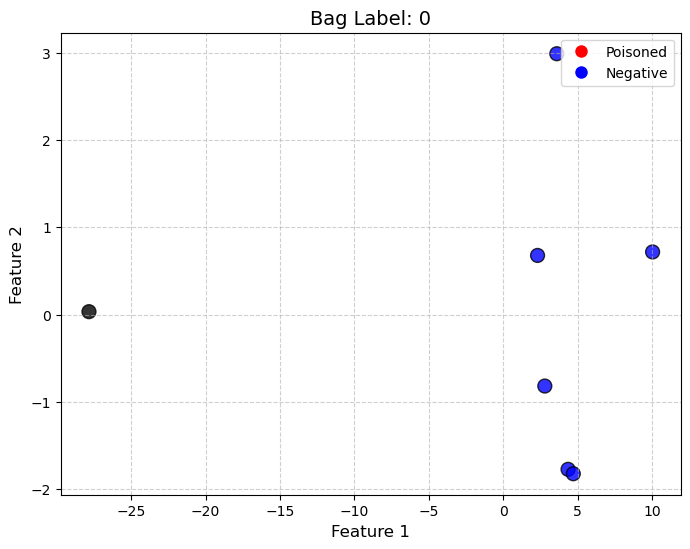

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_bag(bag_data, bag_label, instance_labels, mask=None):
    """
    Visualiza una bolsa de instancias en 2D, coloreando según su etiqueta.
    - Positive (1): Rojo
    - Negative (0): Azul
    - Poisoned (-1): Negro
    - Padding (-2): Gris (no se muestran si se usa la máscara)
    """
    # Filtrar instancias rellenas (padding)
    if mask is not None:
        valid_indices = mask.bool().squeeze()
        bag_data = bag_data[valid_indices]
        instance_labels = instance_labels[valid_indices]
    
    # Reducir dimensionalidad a 2D si es necesario
    if bag_data.shape[1] > 2:
        pca = PCA(n_components=2)
        projected_data = pca.fit_transform(bag_data.numpy())
        bag_data = torch.tensor(projected_data)
    
    # Crear scatter plot
    plt.figure(figsize=(8, 6))
    colors = []
    labels = []
    for label in instance_labels:
        if label == 1:
            colors.append('red')
            labels.append('Positive')
        elif label == 0:
            colors.append('blue')
            labels.append('Negative')
        elif label == -1:
            colors.append('black')
            labels.append('Poisoned')
        else:
            colors.append('gray')
            labels.append('Padding')

    plt.scatter(
        bag_data[:, 0], 
        bag_data[:, 1], 
        c=colors,
        s=100,
        alpha=0.8,
        edgecolor='black'
    )
    
    # Añadir leyenda y título
    unique_labels = list(set(labels))
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
               for color, label in zip(['red', 'blue', 'black', 'gray'], unique_labels)]
    plt.legend(handles, unique_labels)
    plt.title(f"Bag Label: {bag_label.item()}", fontsize=14)
    plt.xlabel("Feature 1 (PCA)" if bag_data.shape[1] > 2 else "Feature 1", fontsize=12)
    plt.ylabel("Feature 2 (PCA)" if bag_data.shape[1] > 2 else "Feature 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Visualizar un ejemplo de cada dataset
print("=== SCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== MCStandard Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in mc_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("=== False Frequency Dataset ===")
for bag_data, bag_label, instance_labels, adj_mat, mask in false_freq_loader:
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

VISUALIZACIÓN DE EJEMPLOS DE CADA CONJUNTO DE DATOS

1. CONJUNTO DE DATOS SC-STANDARD (Single Concept)
Este dataset contiene bolsas donde un solo concepto determina la etiqueta
Forma de los datos: torch.Size([7, 10])
Etiqueta de la bolsa: 1 (Positiva)
Número de instancias: 7


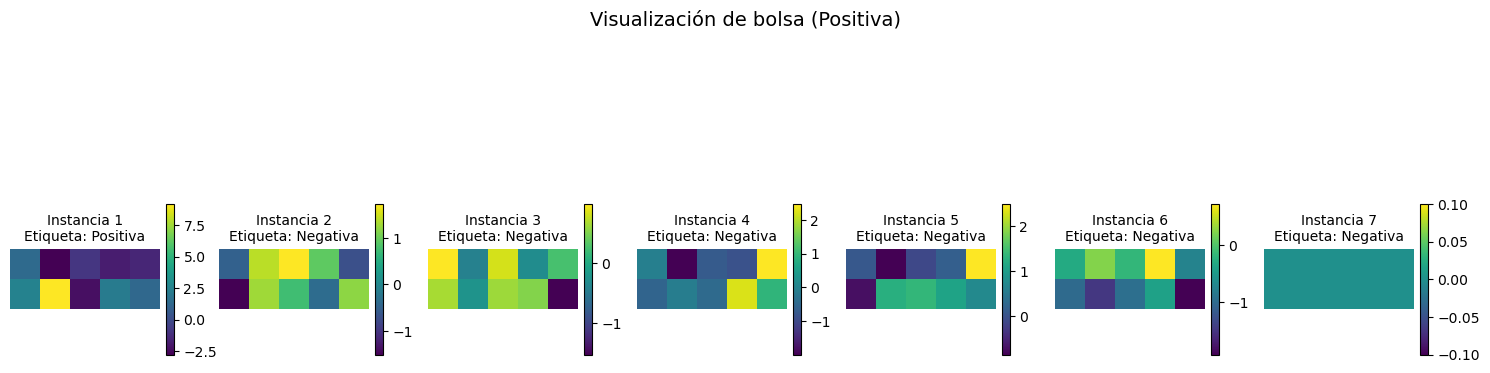


2. CONJUNTO DE DATOS MC-STANDARD (Multiple Concept)
Este dataset contiene bolsas donde múltiples conceptos determinan la etiqueta
Forma de los datos: torch.Size([12, 10])
Etiqueta de la bolsa: 1 (Positiva)
Número de instancias: 12


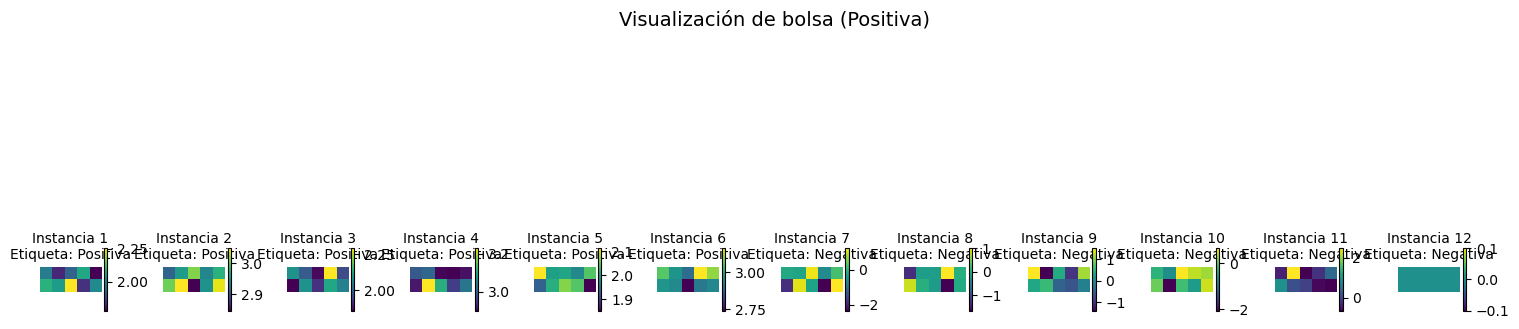


3. CONJUNTO DE DATOS FALSE FREQUENCY
Este dataset contiene bolsas con correlaciones engañosas de frecuencia
Forma de los datos: torch.Size([9, 10])
Etiqueta de la bolsa: 0 (Negativa)
Número de instancias: 9


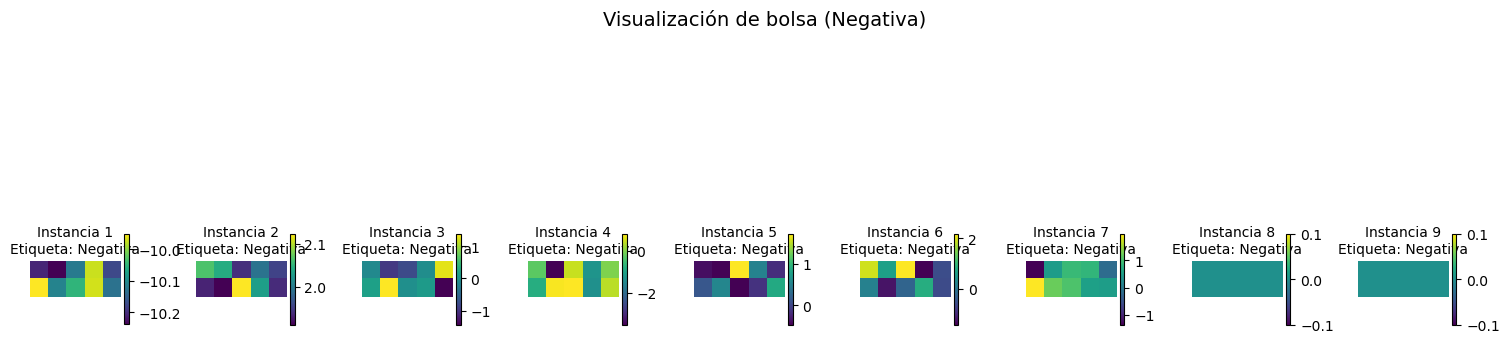

In [18]:
def visualize_bag(bag_data, bag_label, instance_labels):
    """
    Visualiza una bolsa de instancias junto con sus etiquetas.
    
    Parámetros:
    - bag_data: Tensor con las instancias de la bolsa
    - bag_label: Etiqueta global de la bolsa (0: negativa, 1: positiva)
    - instance_labels: Etiquetas individuales de cada instancia dentro de la bolsa
    
    Esta función crea una visualización con todas las instancias de una bolsa,
    mostrando para cada una su representación gráfica y su etiqueta correspondiente.
    """
    # Mostrar información general de la bolsa
    bag_label_text = "Positiva" if bag_label.item() == 1 else "Negativa"
    print(f"Etiqueta de la bolsa: {bag_label.item()} ({bag_label_text})")
    print(f"Número de instancias: {len(bag_data)}")
    
    # Configurar el tamaño de la figura basado en el número de instancias
    plt.figure(figsize=(min(15, 3 * len(bag_data)), 5))
    
    # Crear una visualización para cada instancia
    for i, instance in enumerate(bag_data):
        plt.subplot(1, len(bag_data), i + 1)
        
        # Obtener y formatear la etiqueta de la instancia
        inst_label = instance_labels[i].item()
        inst_label_text = "Positiva" if inst_label == 1 else "Negativa"
        
        # Título más descriptivo
        plt.title(f"Instancia {i+1}\nEtiqueta: {inst_label_text}", fontsize=10)
        
        # Visualizar los datos de la instancia como una imagen 2D
        # Los datos se reorganizan a una forma de 2 filas x N columnas
        plt.imshow(instance.numpy().reshape(2, -1), cmap="viridis")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis("off")
    
    # Añadir un título general para toda la figura
    plt.suptitle(f"Visualización de bolsa ({bag_label_text})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar para el título general
    plt.show()

# Visualizar un ejemplo de cada conjunto de datos
print("=" * 50)
print("VISUALIZACIÓN DE EJEMPLOS DE CADA CONJUNTO DE DATOS")
print("=" * 50)

print("\n1. CONJUNTO DE DATOS SC-STANDARD (Single Concept)")
print("Este dataset contiene bolsas donde un solo concepto determina la etiqueta")
for bag_data, bag_label, instance_labels, adj_mat, mask in sc_loader:
    print(f"Forma de los datos: {bag_data[0].shape}")
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("\n2. CONJUNTO DE DATOS MC-STANDARD (Multiple Concept)")
print("Este dataset contiene bolsas donde múltiples conceptos determinan la etiqueta")
for bag_data, bag_label, instance_labels, adj_mat, mask in mc_loader:
    print(f"Forma de los datos: {bag_data[0].shape}")
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

print("\n3. CONJUNTO DE DATOS FALSE FREQUENCY")
print("Este dataset contiene bolsas con correlaciones engañosas de frecuencia")
for bag_data, bag_label, instance_labels, adj_mat, mask in false_freq_loader:
    print(f"Forma de los datos: {bag_data[0].shape}")
    visualize_bag(bag_data[0], bag_label[0], instance_labels[0])
    break

In [7]:
# Configuración para SCStandard
D = 10  # ¡Ajusta esto según el dataset!
FEATURE_DIM = 64  # Ejemplo: reduce a 64 para SCStandard
POOLING_TYPE = "attention"

# Instanciar el modelo con las dimensiones correctas
model = MILModel(
    input_feature_dim=D,  # Usa D=10 para SCStandard
    feature_dim=FEATURE_DIM,
    pooling_type=POOLING_TYPE,
    dropout_prob=0.5
).to(DEVICE)

# Función de pérdida y optimizador
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [8]:
def train_model(loader, model, criterion, optimizer, epochs=NUM_EPOCHS):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for bag_data, bag_label, instance_labels, adj_mat, mask in loader:
            bag_data, bag_label = bag_data.to(DEVICE), bag_label.float().to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None

            optimizer.zero_grad()
            predictions, _ = model(bag_data, mask=mask)
            loss = criterion(predictions.squeeze(), bag_label)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [9]:
def evaluate_model(loader, model):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for bag_data, bag_label, _, _, mask in loader:
            bag_data = bag_data.to(DEVICE)
            mask = mask.to(DEVICE) if mask is not None else None
            output, _ = model(bag_data, mask=mask)
            preds = (torch.sigmoid(output) > 0.5).float().squeeze().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(bag_label.cpu().numpy())
    
    # Calcular métricas
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    auc = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}, F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

In [10]:
# SCStandard Dataset
print("=== Entrenando en SCStandard Dataset ===")
train_model(sc_loader, model, criterion, optimizer)

print("=== Evaluando en SCStandard Dataset ===")
evaluate_model(sc_loader, model)

# MCStandard Dataset
print("=== Entrenando en MCStandard Dataset ===")
train_model(mc_loader, model, criterion, optimizer)

print("=== Evaluando en MCStandard Dataset ===")
evaluate_model(mc_loader, model)

# False Frequency Dataset
print("=== Entrenando en False Frequency Dataset ===")
train_model(false_freq_loader, model, criterion, optimizer)

print("=== Evaluando en False Frequency Dataset ===")
evaluate_model(false_freq_loader, model)

=== Entrenando en SCStandard Dataset ===
Epoch 1/10, Loss: 9.6357
Epoch 2/10, Loss: 6.4990
Epoch 3/10, Loss: 5.0450
Epoch 4/10, Loss: 3.7146
Epoch 5/10, Loss: 3.2345
Epoch 6/10, Loss: 2.3033
Epoch 7/10, Loss: 1.8871
Epoch 8/10, Loss: 1.4423
Epoch 9/10, Loss: 1.1912
Epoch 10/10, Loss: 0.9293
=== Evaluando en SCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
Confusion Matrix:
[[50  0]
 [ 0 50]]
=== Entrenando en MCStandard Dataset ===
Epoch 1/10, Loss: 0.3023
Epoch 2/10, Loss: 0.1540
Epoch 3/10, Loss: 0.0754
Epoch 4/10, Loss: 0.0716
Epoch 5/10, Loss: 0.0578
Epoch 6/10, Loss: 0.0657
Epoch 7/10, Loss: 0.0290
Epoch 8/10, Loss: 0.0219
Epoch 9/10, Loss: 0.0723
Epoch 10/10, Loss: 0.0441
=== Evaluando en MCStandard Dataset ===
Accuracy: 1.0000, AUC: 1.0000, F1-Score: 1.0000
Confusion Matrix:
[[50  0]
 [ 0 50]]
=== Entrenando en False Frequency Dataset ===
Epoch 1/10, Loss: 0.0650
Epoch 2/10, Loss: 0.0351
Epoch 3/10, Loss: 0.0286
Epoch 4/10, Loss: 0.0275
Epoch 5/10, Loss: 0.